# Spatial mapping amplitudes and their ratios vs $t_0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE
from qnmfits.spatial_mapping_functions import *

plt.style.use("stylesheet.mplstyle")
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

In [2]:
id = "0001"
sim = CCE.SXS_CCE(id)

l_max = 8
n_max = 7

start = -30
stop = 100
dt = 1

peak_time = 17.0

mapping = [(2, 2, 0, 1)]

In [3]:
start_times = np.arange(start, stop, dt)
time_index = np.abs(start_times - peak_time).argmin()
decay_time = qnmfits.qnm.omega_list([mapping[0]], sim.chif_mag, sim.Mf)[0].imag

lp, mp, nprime, pp = mapping[0]

QNMs = [
    (lam, mu, n, p)
    for lam in np.arange(2, l_max + 1)
    for mu in np.arange(-lam, lam + 1)
    for n in np.arange(0, n_max + 1)
    for p in (-1, +1)
]

spherical_modes = [(l, m) for l in range(2, l_max + 1) for m in range(-l, l + 1)]

l = lp
m = mp

sphindex22 = spherical_modes.index((l, m))
sphindex32 = spherical_modes.index((l + 1, m))
sphindex42 = spherical_modes.index((l + 2, m))

indices22 = [(l, m) + mapping[0]]
indices32 = [(l + 1, m) + mapping[0]]
indices42 = [(l + 2, m) + mapping[0]]

In [ ]:
# Get the spatial mapping amplitudes (including other simulation levels for an error estimate)

amplitude_arrays = {}

for lev in ["Lev4", "Lev5"]:
    for rad in ["R2", "R3"]:

        name = f"{lev}_{rad}"
        amplitude_array = np.zeros((len(start_times), len(spherical_modes)))

        sim = CCE.SXS_CCE(id, lev=lev, radius=rad)

        for i, step in enumerate(start_times):

            best_fit = mapping_multimode_ringdown_fit(
                sim.times,
                sim.h,
                modes=QNMs.copy(),
                Mf=sim.Mf,
                chif=sim.chif_mag,
                t0=step,
                mapping_modes=mapping,
                spherical_modes=spherical_modes.copy(),
            )

            amplitude_array[i, :] = np.abs(best_fit["C"][len(QNMs) - 1 :])

        amplitude_arrays[name] = amplitude_array

In [ ]:
# Determine amplitude ratios for the various levels to determine an error estimate

min_prediction22 = amplitude_arrays["Lev5_R2"][:, sphindex22]
max_prediction22 = amplitude_arrays["Lev5_R2"][:, sphindex22]

min_prediction32 = amplitude_arrays["Lev5_R2"][:, sphindex32]
max_prediction32 = amplitude_arrays["Lev5_R2"][:, sphindex32]

min_prediction42 = amplitude_arrays["Lev5_R2"][:, sphindex42]
max_prediction42 = amplitude_arrays["Lev5_R2"][:, sphindex42]

for lev in ["Lev4", "Lev5"]:
    for rad in ["R2", "R3"]:
        min_prediction22 = np.minimum(
            min_prediction22, amplitude_arrays[f"{lev}_{rad}"][:, sphindex22]
        )
        max_prediction22 = np.maximum(
            max_prediction22, amplitude_arrays[f"{lev}_{rad}"][:, sphindex22]
        )

        min_prediction32 = np.minimum(
            min_prediction32, amplitude_arrays[f"{lev}_{rad}"][:, sphindex32]
        )
        max_prediction32 = np.maximum(
            max_prediction32, amplitude_arrays[f"{lev}_{rad}"][:, sphindex32]
        )

        min_prediction42 = np.minimum(
            min_prediction42, amplitude_arrays[f"{lev}_{rad}"][:, sphindex42]
        )
        max_prediction42 = np.maximum(
            max_prediction42, amplitude_arrays[f"{lev}_{rad}"][:, sphindex42]
        )

min_ratio1 = [abs(a / b) for a, b in zip(min_prediction22, max_prediction32)]
max_ratio1 = [abs(a / b) for a, b in zip(max_prediction22, min_prediction32)]

min_ratio2 = [abs(a / b) for a, b in zip(min_prediction22, max_prediction42)]
max_ratio2 = [abs(a / b) for a, b in zip(max_prediction22, min_prediction42)]

/tmp/ipykernel_1962775/2131619049.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", 6)


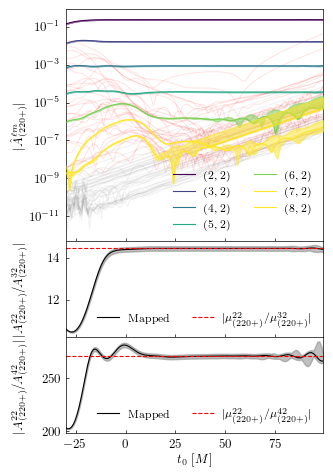

In [ ]:
colors = plt.cm.get_cmap("viridis", 6)

fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(fig_width, fig_height * 2.3),
    sharex=True,
    gridspec_kw={"height_ratios": [2.4, 1, 1], "wspace": 0, "hspace": 0},
)


for col_index in range(amplitude_array.shape[1]):
    l_i, m_i = spherical_modes[col_index]
    C = amplitude_arrays["Lev5_R2"][:, col_index]
    # Correct for decay
    C_tau = C * np.exp(decay_time * (peak_time - start_times))
    # Highlight even m modes in red and odd m modes in grey
    if m_i != m:
        if m_i % 2 == 0:
            alpha = 0.1
            color = "r"
            label = None

        else:
            alpha = 0.1
            color = "grey"
            label = None

        ax[0].plot(start_times, C_tau, alpha=alpha, label=label, color=color, zorder=1)

    # If the mode mixes with the mapped QNM, colour it in bold and include a shaded region for the error estimate
    elif m_i == m:
        alpha = 1
        color = colors(l_i - 2)
        label = f"{spherical_modes[col_index]}"

        min_prediction = amplitude_arrays["Lev5_R2"][:, col_index]
        max_prediction = amplitude_arrays["Lev5_R2"][:, col_index]

        for lev in ["Lev4", "Lev5"]:
            for rad in ["R2", "R3"]:
                min_prediction = np.minimum(
                    min_prediction, amplitude_arrays[f"{lev}_{rad}"][:, col_index]
                )
                max_prediction = np.maximum(
                    max_prediction, amplitude_arrays[f"{lev}_{rad}"][:, col_index]
                )

        ax[0].fill_between(
            start_times,
            min_prediction * np.exp(decay_time * (peak_time - start_times)),
            max_prediction * np.exp(decay_time * (peak_time - start_times)),
            alpha=0.5,
            color=color,
            zorder=3,
        )

        ax[0].plot(start_times, C_tau, alpha=alpha, label=label, color=color, zorder=2)

ax[0].set_ylabel(r"$|\hat{A}^{\ell m}_{(220+)}|$")
ax[0].set_yscale("log")
ax[0].legend(loc="lower right", ncol=2)

amplitudes22 = amplitude_arrays["Lev5_R2"][:, sphindex22]
amplitudes32 = amplitude_arrays["Lev5_R2"][:, sphindex32]
amplitudes42 = amplitude_arrays["Lev5_R2"][:, sphindex42]

# Plot amplitude ratios with a shaded region for the error estimate

ratio1 = [abs(a / b) for a, b in zip(amplitudes22, amplitudes32)]
ax[1].plot(np.arange(start, stop, dt), ratio1, label=f"Mapped", c="k")
ax[1].fill_between(start_times, min_ratio1, max_ratio1, color="grey", alpha=0.5)

ratio2 = [abs(a / b) for a, b in zip(amplitudes22, amplitudes42)]
ax[2].plot(np.arange(start, stop, dt), ratio2, label=f"Mapped", c="k")
ax[2].fill_between(start_times, min_ratio2, max_ratio2, color="grey", alpha=0.5)

mu22 = qnmfits.qnm.mu(l, m, lp, mp, nprime, pp, sim.chif_mag)
mu32 = qnmfits.qnm.mu(l + 1, m, lp, mp, nprime, pp, sim.chif_mag)
mu42 = qnmfits.qnm.mu(l + 2, m, lp, mp, nprime, pp, sim.chif_mag)

ax[1].axhline(
    y=abs(mu22 / mu32),
    color="r",
    linestyle="--",
    label="$|\mu^{22}_{(220+)}/\mu^{32}_{(220+)}|$",
)
ax[2].axhline(
    y=abs(mu22 / mu42),
    color="r",
    linestyle="--",
    label="$|\mu^{22}_{(220+)}/\mu^{42}_{(220+)}|$",
)

ax[1].set_ylabel("$|A^{22}_{(220+)}/A^{32}_{(220+)}|$", fontsize=9)
ax[2].set_ylabel("$|A^{22}_{(220+)}/A^{42}_{(220+)}|$", fontsize=9)

ax[2].set_xlim(start_times[0], start_times[-1])
ax[2].set_xlabel("$t_0 \ [M]$")

ax[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.54, 0))
ax[2].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.54, 0))

ax[0].yaxis.set_label_coords(-0.15, 0.5)
ax[1].yaxis.set_label_coords(-0.15, 0.5)
ax[2].yaxis.set_label_coords(-0.15, 0.5)

fig.savefig("figs/amplitude_ratios_t0.pdf", bbox_inches="tight")